In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import skimage.io
from scipy.spatial.distance import cdist

import sys
sys.path.insert(0,'../')
from helper import classification_tools as ct
from helper import visualize as vis

%matplotlib inline

# Standard Analysis

## Loading data
We already have the file paths, features, and labels from the last step, so we just need to retrieve it from disk

In [2]:
fc1_path = Path('..','data','features','VGG16_fc1_features_std.pickle')
assert fc1_path.is_file()

le_path = Path('..','models','label_encoder.pickle')
assert le_path.is_file()


with open(fc1_path, 'rb') as f:
    data = pickle.load(f)

with open(le_path, 'rb') as f:
    le = pickle.load(f)


In [3]:
files = data['filename']
fc1 = data['features']
labels = data['labels']
y_gt = le.transform(labels)
labels_ordered = le.inverse_transform(range(len(le.classes_)))

Now we have everything we need to do the analysis!

# Dimension reduction
## PCA
The first step in the analys is PCA, which will reduce the dimensionality of the data and hopefully filter out noise.
The question is- how many dimensions to keep?
There is no right answer, but we want to keep components that contain signal (ie significant variance) and get rid of ones
that are mostly noise. For high dimensional data, like our fc1 features, a rule of thumb is to select 50 components. Before blindly
selecting 50, we will see how much variance each component preserves.

variance preserved by 50 components: 0.736


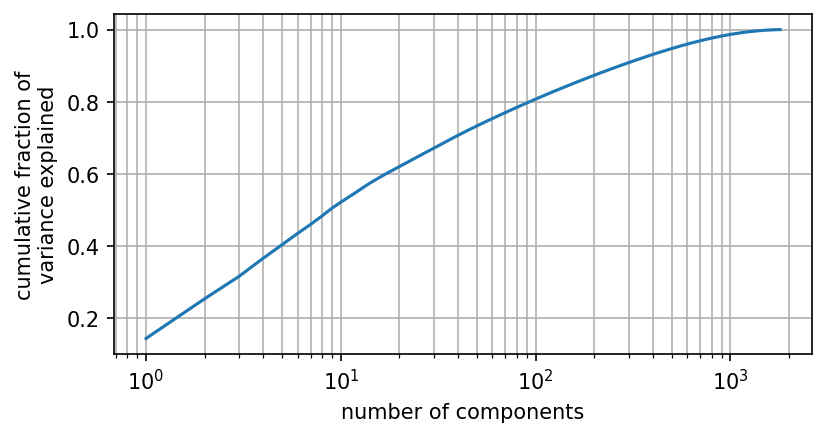

In [4]:
pca_n = PCA(svd_solver='full')
x_pca_ = pca_n.fit_transform(fc1)

var_ = pca_n.explained_variance_ratio_.cumsum()


fig, ax = plt.subplots(figsize=(6,3),dpi=150,)
ax.grid('on', which='both')
ax.plot(range(1,len(var_)+1), var_)
ax.set_xscale('log')
ax.set_xlabel('number of components')
ax.set_ylabel('cumulative fraction of\nvariance explained')
print('variance preserved by 50 components: {:.3f}'.format(var_[50]))

50 components preserves  73.6% of the variance, so it seems to be a reasonable starting point for this task.
Let's proceed to extract 50 components. We will also look at a setting called whitening, which normalizes the variance 
across each component after doing the decomposition. Think of this as weighting all of the components equally.

## T-SNE Visualization
T-SNE maps components in high-dimensional space to lower dimensions. It is commonly used to project data to 2d for visualization. 
This technique aims to preserve pairwise distances for points that are close to each other, and does not preserve distances for points that are far away from each other.

In [5]:
pca = PCA(n_components=50, svd_solver='full', whiten=True)
pca_nw = PCA(n_components=50, svd_solver='full', whiten=False)
x = pca.fit_transform(fc1)
x_nw = pca_nw.fit_transform(fc1)

In [6]:
tsne = TSNE(n_components=2, random_state=12214)
tsne_w = TSNE(n_components=2, random_state=654753)
x_nw_tsne = tsne.fit_transform(x_nw)
x_w_tsne = tsne_w.fit_transform(x)

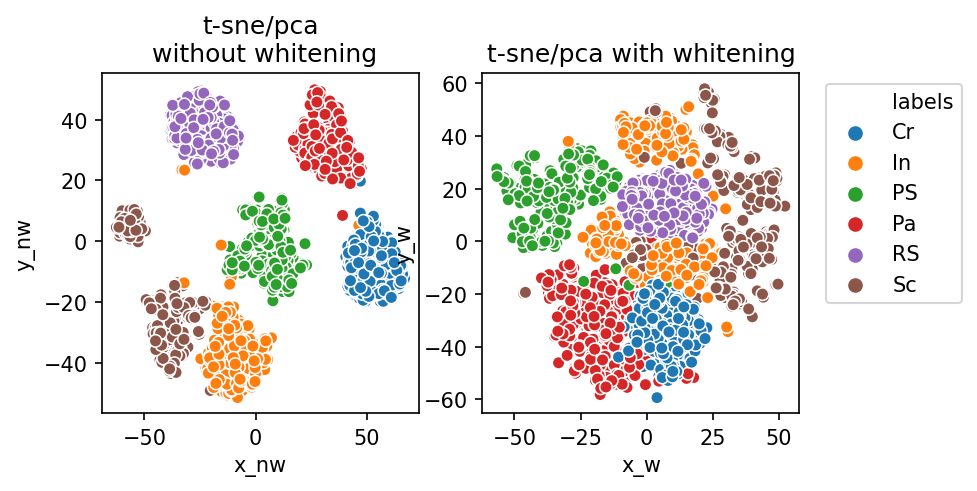

In [7]:
df = pd.DataFrame({'files': files,
                   'x_nw':x_nw_tsne[:,0],
                   'y_nw':x_nw_tsne[:,1],
                   'x_w': x_w_tsne[:,0],
                  'y_w': x_w_tsne[:,1],
                   'labels': labels,
                  },
                  index=files)

fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=150)
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=labels_ordered,  ax=ax[0])
sns.scatterplot(data=df, x='x_w', y='y_w', hue='labels', hue_order=labels_ordered, ax=ax[1])
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05,1))
ax[0].set_title('t-sne/pca\n without whitening')
ax[1].set_title('t-sne/pca with whitening')
plt.show()

The t-sne map without whitening shows much better clustering than the t-sne map with whitened components. However, as we will see, this turns out to be an artifact of t-sne, and
does not represent the actual clustering of the data in feature space. Whitening normalizes the variance, and therefore pairwise distances of points in feature space, so they do not
cluster in 2d as well. Despite this, we will see that they actually cluster better in feature space with whitening.

## We can also plot the images on the t-sne plot to see if we can gain any insights from the data

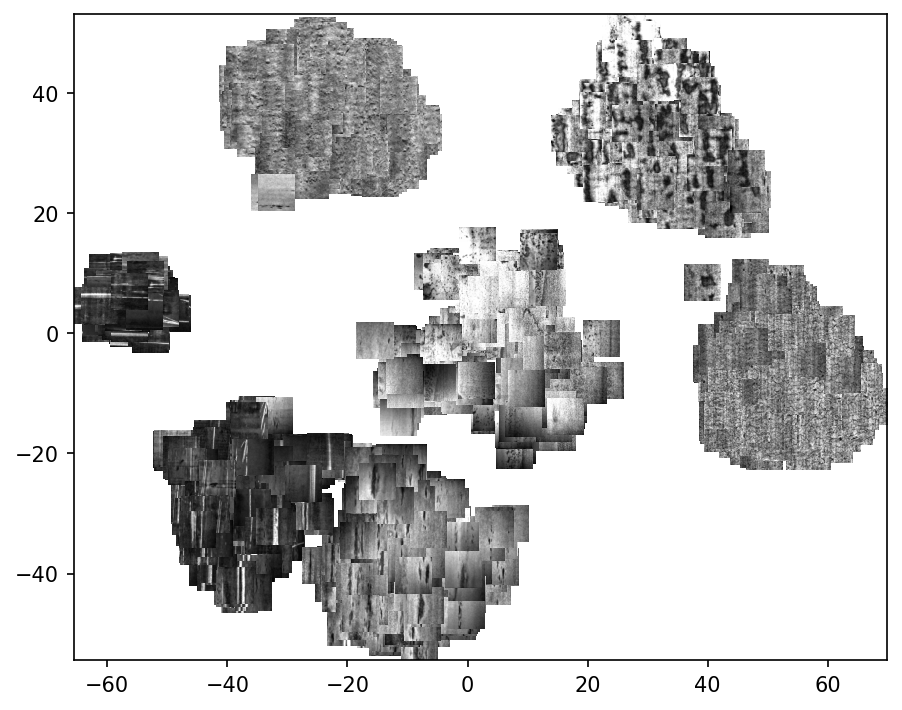

In [8]:
vis.pano_plot(x_nw_tsne[:,0], x_nw_tsne[:,1], files)

We can see how the clusters separate very well by defect class. Notice that for scratches there appear to be two different clusters? This has to do with the orientation of the scratches- one for vertical, and the other for horizontal. The vertical scratches cluster is close to the inclusions, and we can see some visual similarity between these groups. However, the horizontal scratches appear in a separate, distinct cluster.

# Clustering
Now we can cluster the data with K-means. The process is very straightforward.

In [9]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=500,random_state=13)
kmeans.fit(x)
labels_unmatched = kmeans.labels_  # labels from k-means are arbitrary and must be mapped to the format of the ground truth labels
y_pred = ct.label_matcher(labels_unmatched, y_gt,)  # this function matches the labels so we can compare directly
print('inertia: {:.2f}'.format(kmeans.inertia_))


inertia: 80410.47


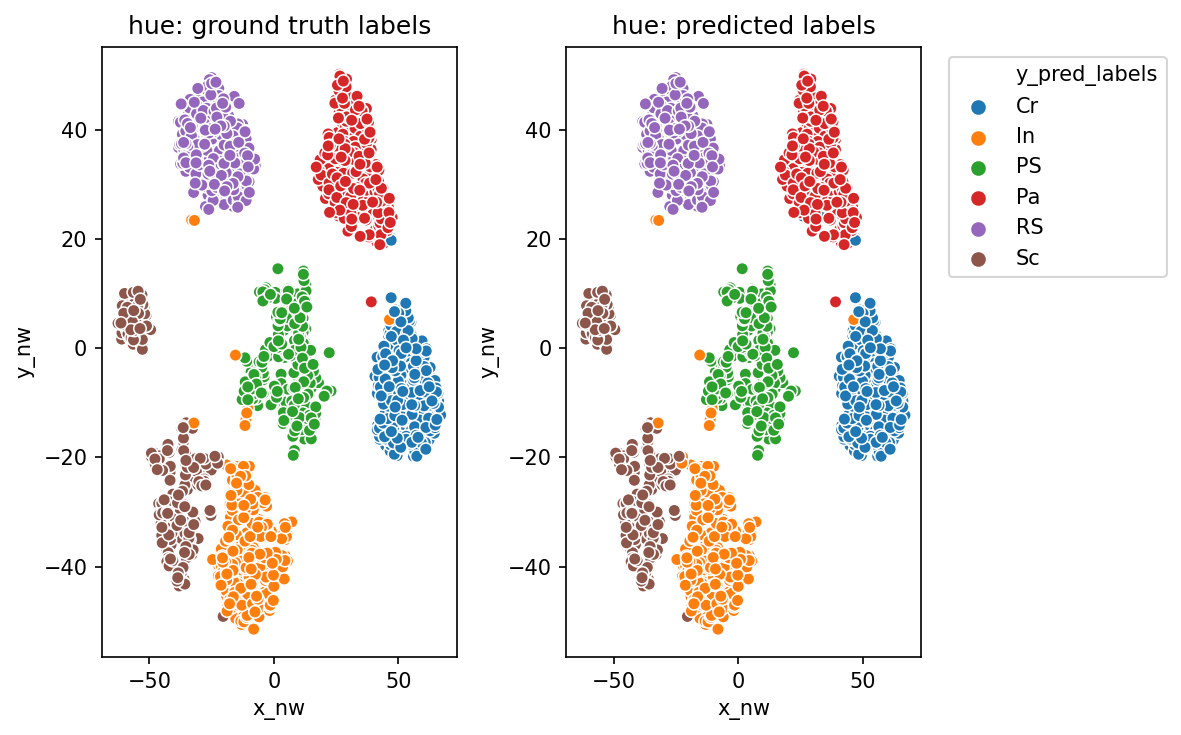

In [10]:
y_pred_str = le.inverse_transform(y_pred)
df['y_pred_labels'] = pd.Series(y_pred_str, index=files)

fig, ax = plt.subplots(1,2, figsize=(8,5), dpi=150)


sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=labels_ordered, ax=ax[0]) # ground truth labels
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='y_pred_labels', hue_order=labels_ordered, ax=ax[1]) # predicted labels

ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05,1))
ax[0].set_title('hue: ground truth labels')
ax[1].set_title('hue: predicted labels')
fig.tight_layout()
plt.show()

The colors look identical, confirming we have very good clustering! They are almost exactly the same (ie we did not accidentally plot the same thing twice.) There are very slight differences around (-20,-20) with some of the scratches/inclusions being classified differently.

## Confusion matrix
This let's us visualize the classification performance with more detail.

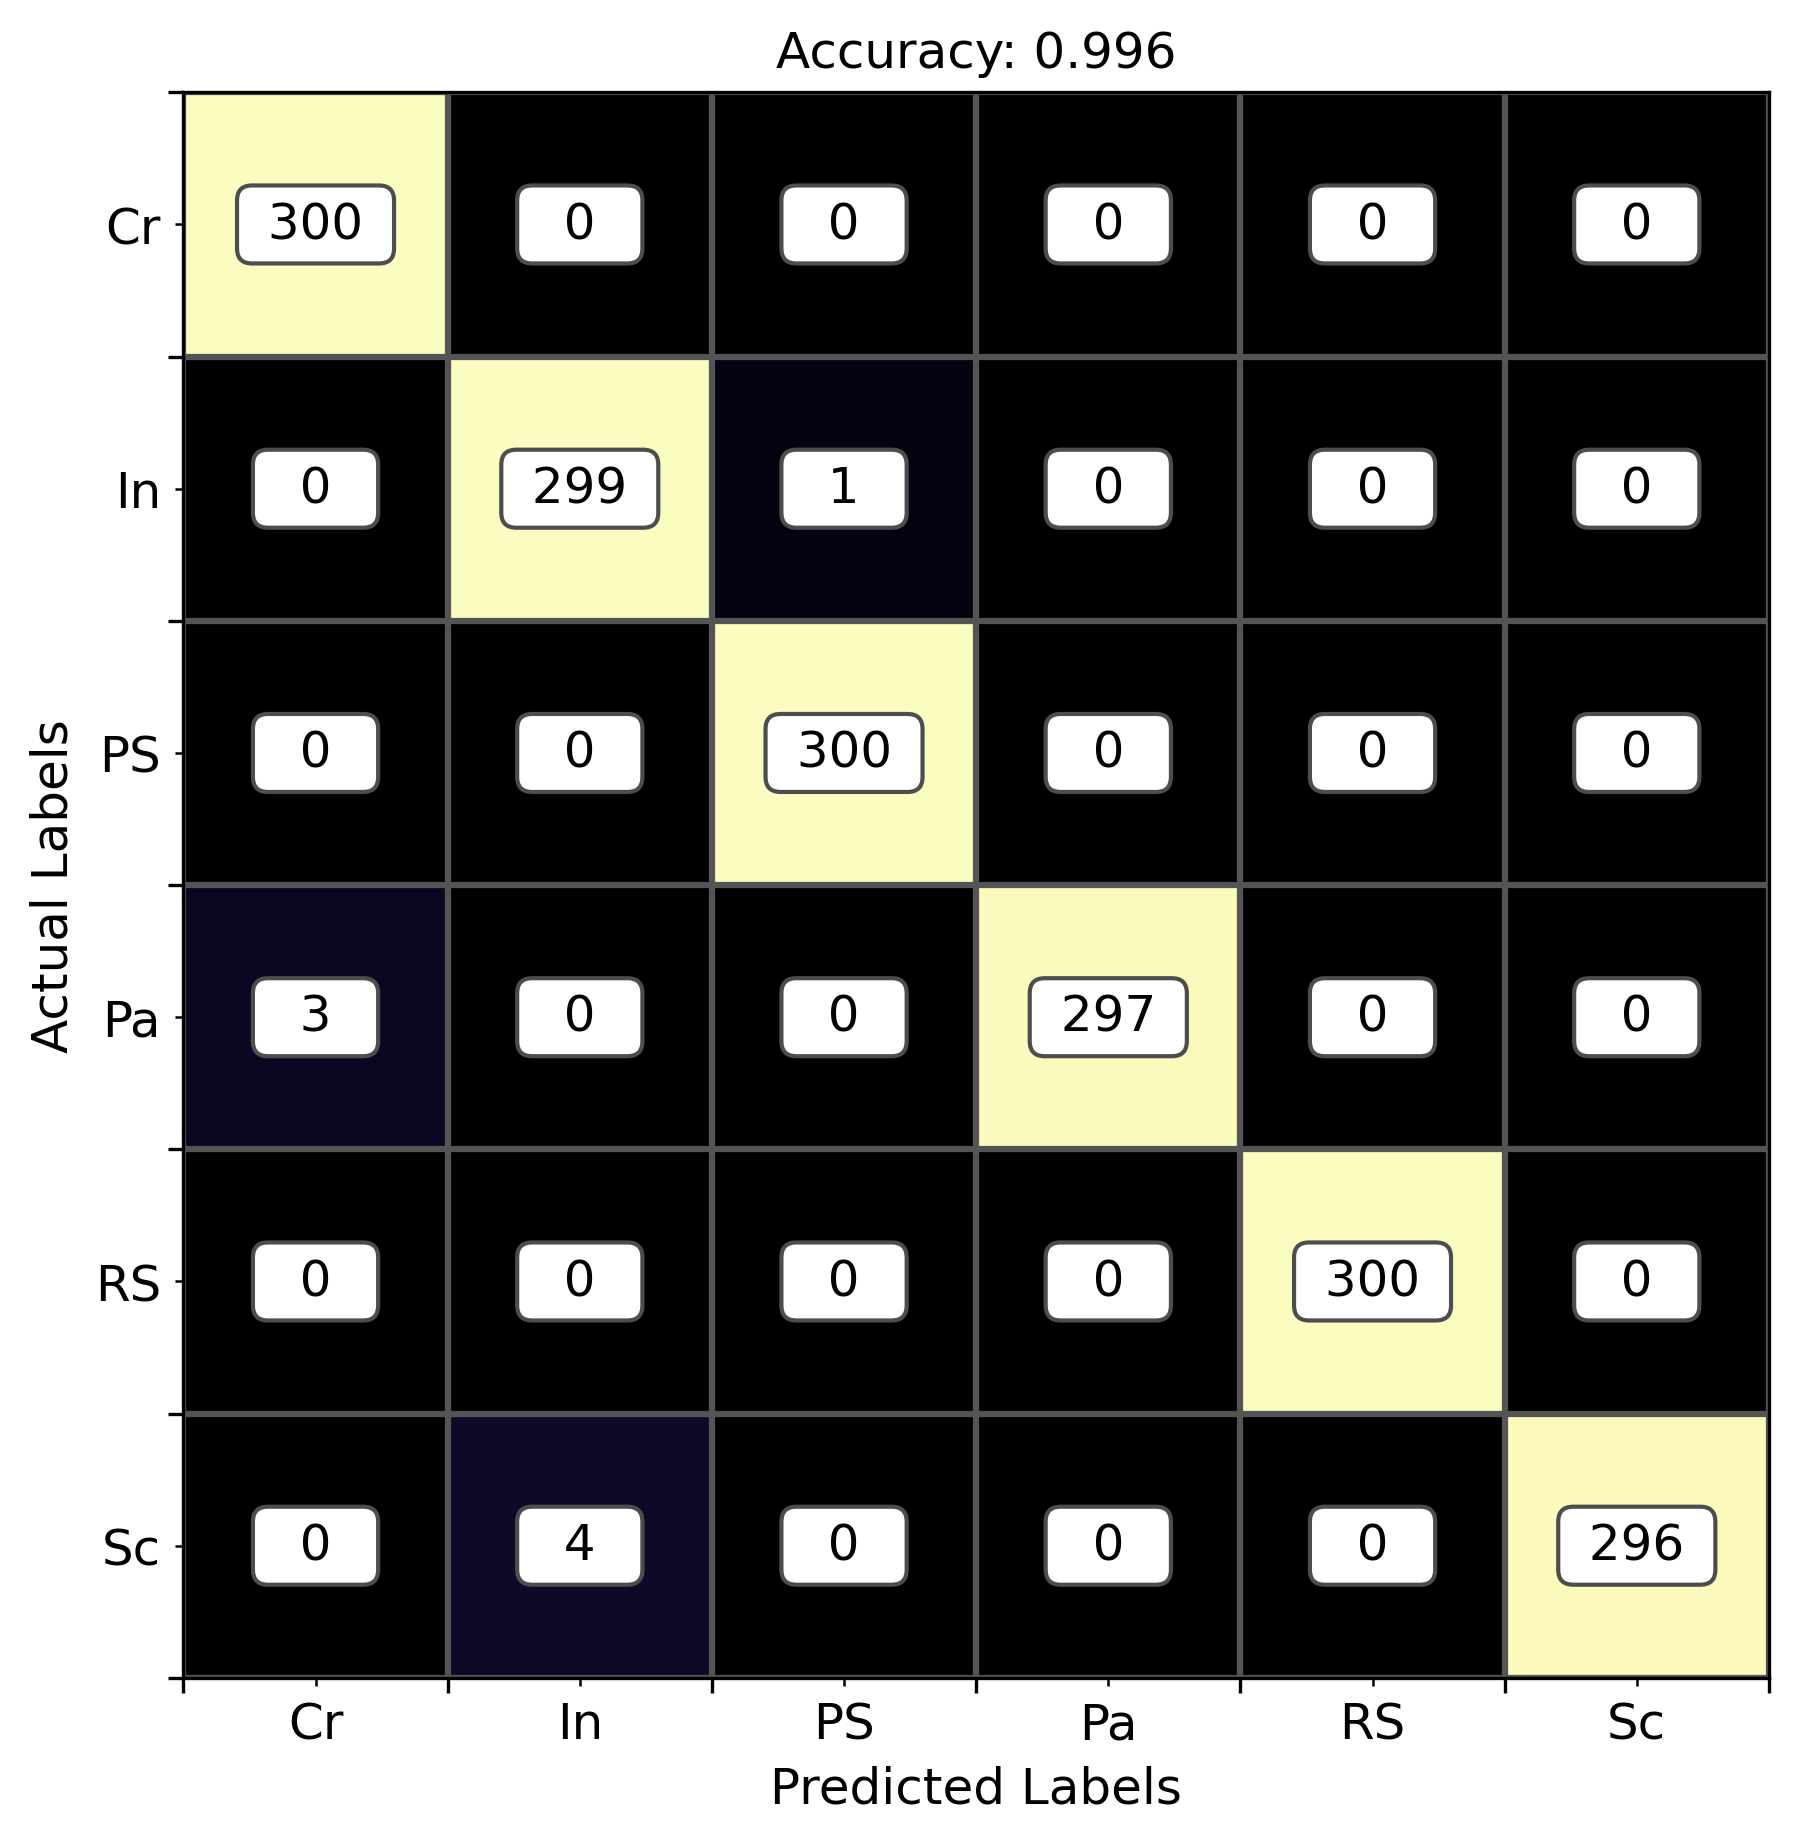

Accuracy: 0.996


In [11]:
# The confusion matrix allows us to evaluate the performance
CM = confusion_matrix(y_gt, y_pred)
vis.pretty_cm(CM, labels_ordered)
print('Accuracy: {:.3f}'.format(CM.trace()/CM.sum()))

99.6% accuracy, pretty good! But did we just get lucky with the random initialization of k-means, or is this process repeatable?

In [12]:
# This takes a couple minutes to run, be patient!
rs = np.random.RandomState(seed=987654321)
accuracies = np.zeros(10)
for i, seed in enumerate(rs.randint(2**32, size=10)):
    print(seed)
    kmeans_ = KMeans(n_clusters=7, init='k-means++', n_init=500,random_state=seed)
    kmeans_.fit(x)
    labels_unmatched_ = kmeans_.labels_
    y_pred_ = ct.label_matcher(labels_unmatched_, y_gt)
    acc = (y_pred_ == y_gt).sum()/len(y_gt)
    print(acc)
    accuracies[i] = acc
    


print(accuracies)

313482503
0.9905555555555555
1226283474
0.995
927869703
0.9944444444444445
3285297254
0.995
1996101040
0.9961111111111111
1316974753
0.9938888888888889
2674003433
0.9916666666666667
3242289495
0.995
2655956761
0.995
2136375907
0.9933333333333333
[0.99055556 0.995      0.99444444 0.995      0.99611111 0.99388889
 0.99166667 0.995      0.995      0.99333333]


In [13]:
print('10 runs:\n\tavg: {:.4f}\n\tstd: {:.4},\n\tmin: {:.4f}'.format(accuracies.mean(), np.std(accuracies), accuracies.min()))

10 runs:
	avg: 0.9940
	std: 0.001625,
	min: 0.9906


The model achieves 99.4 $\pm$ 0.16% accuracy, and all trials achieve above 99% accuracy. Pretty good!

In [14]:
print(classification_report(y_gt, y_pred, target_names=labels_ordered, digits=3))

              precision    recall  f1-score   support

          Cr      0.990     1.000     0.995       300
          In      0.987     0.997     0.992       300
          PS      0.997     1.000     0.998       300
          Pa      1.000     0.990     0.995       300
          RS      1.000     1.000     1.000       300
          Sc      1.000     0.987     0.993       300

    accuracy                          0.996      1800
   macro avg      0.996     0.996     0.996      1800
weighted avg      0.996     0.996     0.996      1800



# Results without whitening
The t-sne projection showed much better clustering without whitening, yet we did clustering with whitening,
Whitening causes t-sne to not work as well, but it actually clusters the points better in the original feature space.
Here is what happens when we perform the same clustering approach on unwhitened pca components.

We will investigate the effects of PCA more in 06_pca_num_components_whiten_nowhiten.ipynb. However, to show why we are using whitening even though the t-sne maps don't look as good, here are the clustering results.

In [15]:
kmeans_nw = KMeans(n_clusters=7, init='k-means++', n_init=500,random_state=13)
kmeans_nw.fit(x_nw)
labels_unmatched_nw = kmeans_nw.labels_  # labels from k-means are arbitrary and must be mapped to the format of the ground truth labels
y_pred_nw = ct.label_matcher(labels_unmatched_nw, y_gt,)  # this function matches the labels so we can compare directly

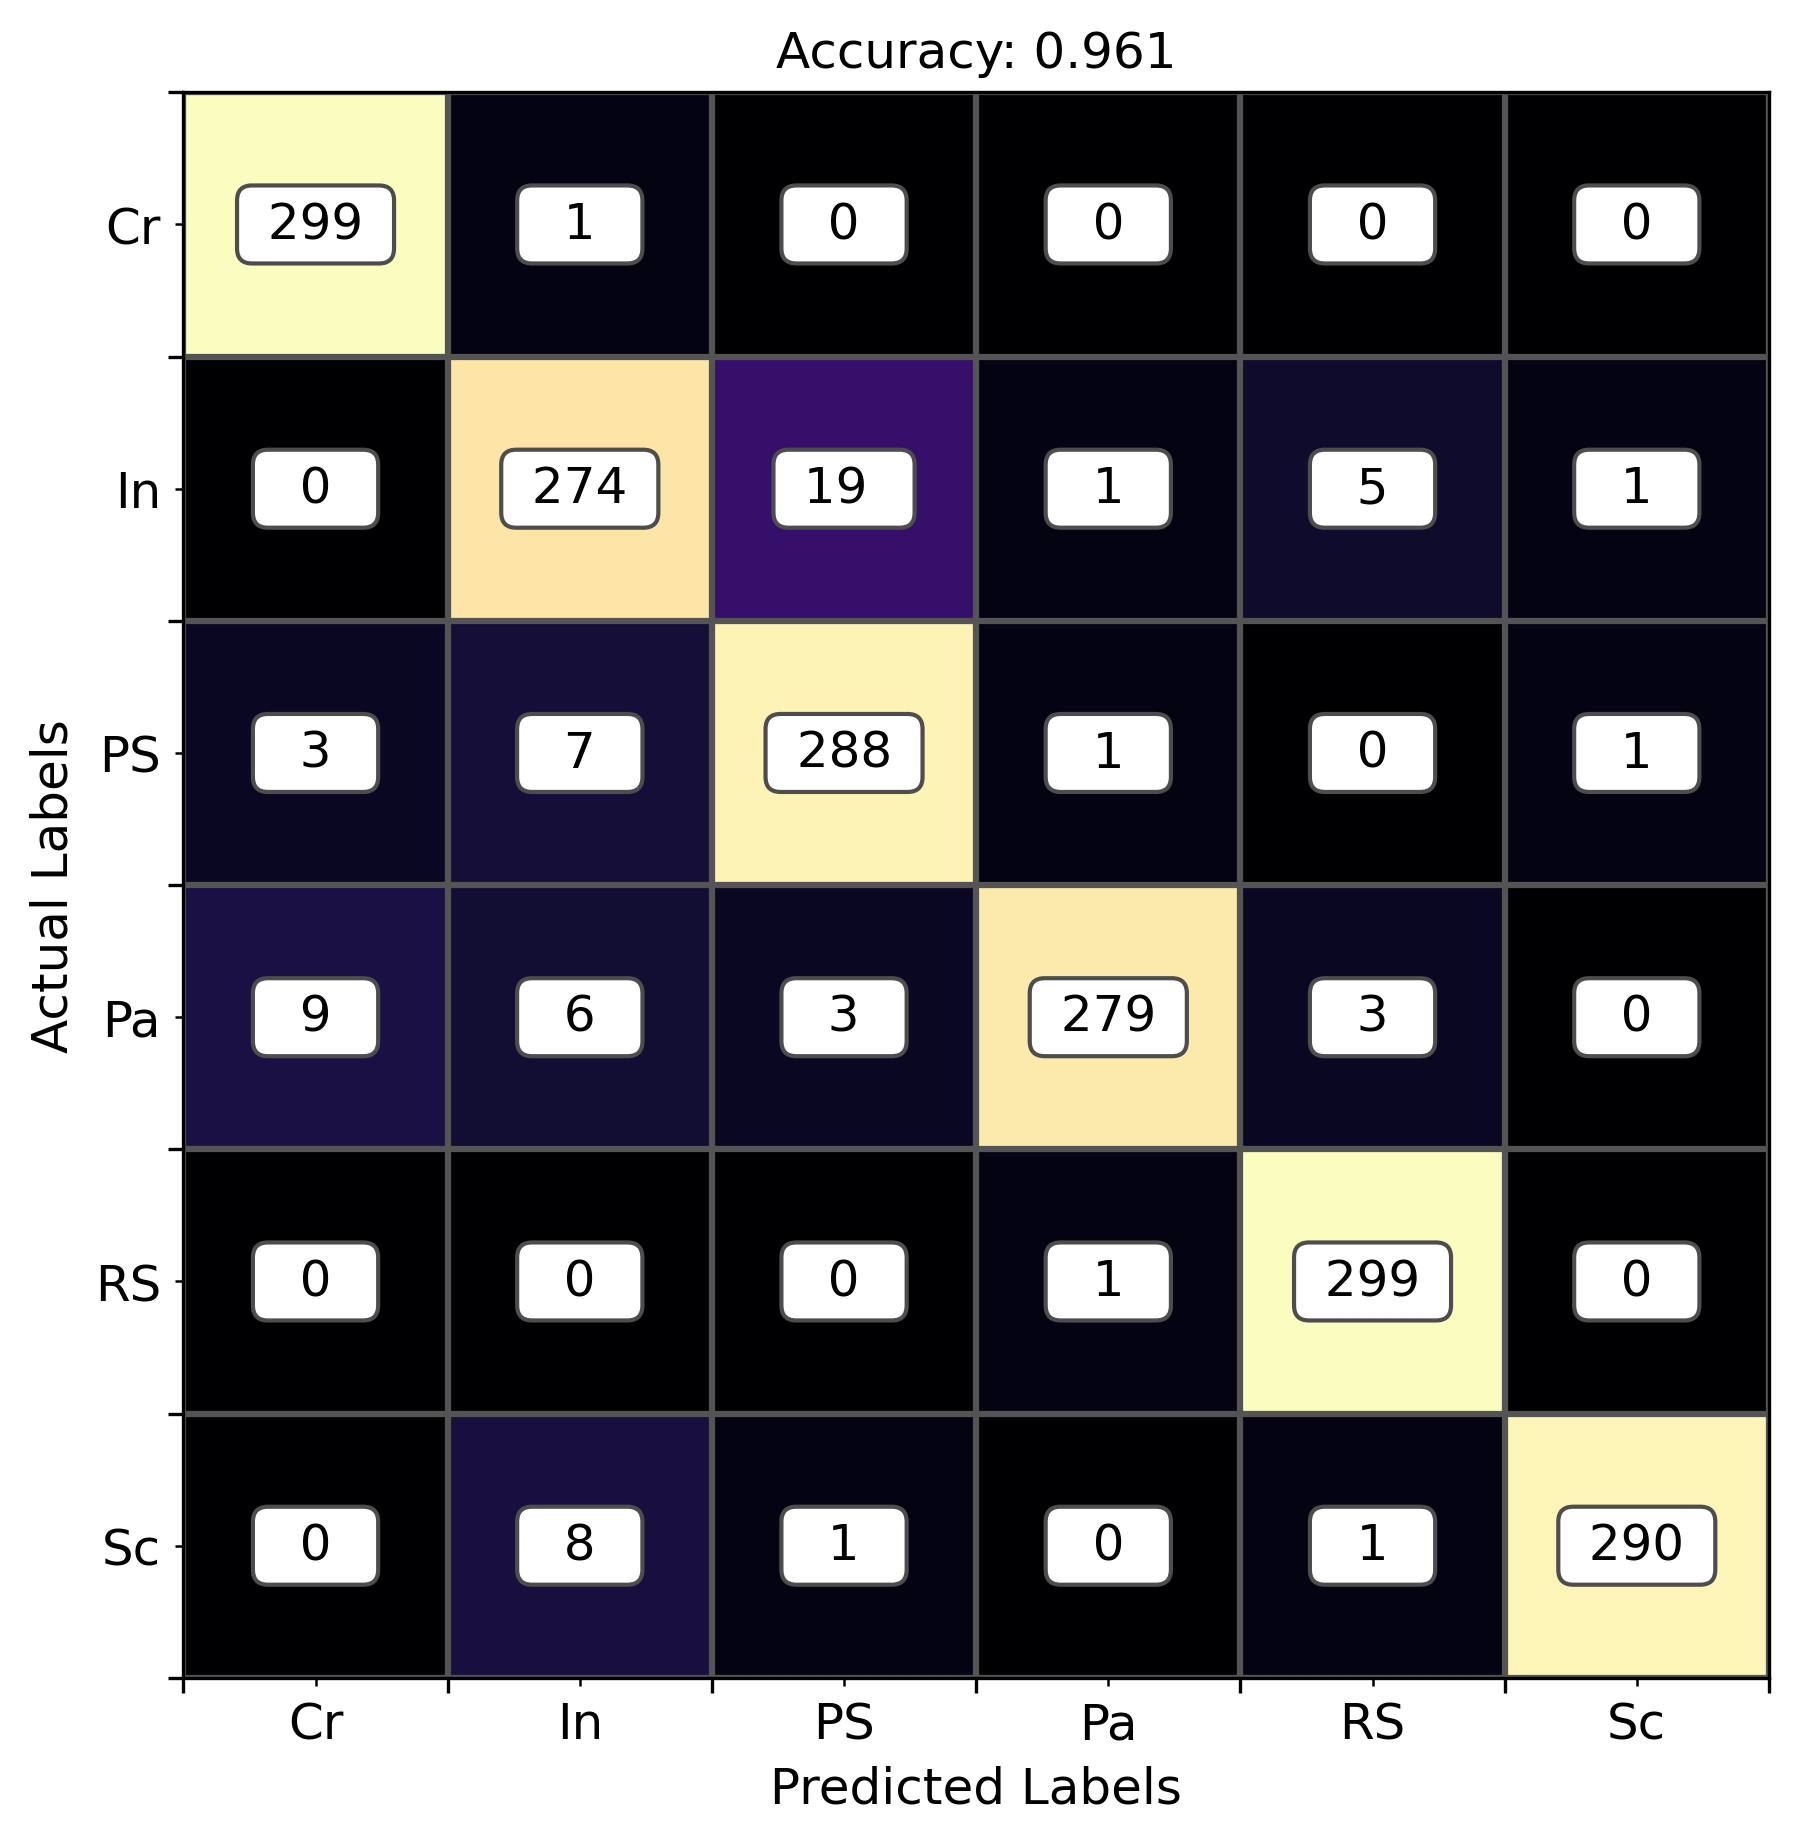

              precision    recall  f1-score   support

          Cr      0.961     0.997     0.979       300
          In      0.926     0.913     0.919       300
          PS      0.926     0.960     0.943       300
          Pa      0.989     0.930     0.959       300
          RS      0.971     0.997     0.984       300
          Sc      0.993     0.967     0.980       300

    accuracy                          0.961      1800
   macro avg      0.961     0.961     0.960      1800
weighted avg      0.961     0.961     0.960      1800



In [16]:
cm_nw = confusion_matrix(y_gt, y_pred_nw)
vis.pretty_cm(cm_nw, labelnames=labels_ordered)

print(classification_report(y_gt, y_pred_nw, target_names=labels_ordered, digits=3))

Clustering still achieves 96% accuracy, but not nearly as good. Whitening helps boost the signal in feature space. This isn't captured by t-sne because information is always lost when projecting down from 50 to 2 dimensions.

# Figures and extras